In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance_matrix
import pandas as pd
import csv

def get_dist_kaggle(file_path):
    coordinates = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            coordinates.append([float(row[0]), float(row[1])])
    coordinates = np.array(coordinates)
    dist_matrix = distance_matrix(coordinates, coordinates)
    return dist_matrix

def get_dist_tsplib(file_path):
    coordinates = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        inside_coords = False
        for row in reader:
            if row and row[0] == 'NODE_COORD_SECTION':  # Start reading coordinates
                inside_coords = True
                continue
            if row and row[0] == 'EOF':  # End of coordinates section
                inside_coords = False
                continue

            if inside_coords:
                # Extract coordinates (ignore the city number)
                x, y = row[0].split(" ")[1], row[0].split(" ")[2]
                coordinates.append((float(x), float(y)))
    dist_matrix = distance_matrix(coordinates, coordinates)
    return dist_matrix


def nearest_neighbor(dist_matrix):
    
    n = dist_matrix.shape[0]

    visited = [0]  # start from the first point (index 0)
    route = [0]
    current_point = 0
    total_distance = 0

    for _ in range(1, n):
        nearest_distance = float('inf')
        nearest_point = -1
        for j in range(n):
            if j not in visited:
                dist = dist_matrix[current_point, j]
                if dist < nearest_distance:
                    nearest_distance = dist
                    nearest_point = j
        visited.append(nearest_point)
        route.append(nearest_point)
        total_distance += nearest_distance
        current_point = nearest_point

    # Return to starting point
    return_distance = dist_matrix[current_point, 0]
    total_distance += return_distance
    route.append(0)

    return total_distance, route

def calcTourLength(hamPath, dist_matrix):
    tourLength=sum(dist_matrix[hamPath[0:-1], hamPath[1:len(hamPath)]])
    tourLength+=dist_matrix[hamPath[-1],hamPath[0]]
    return tourLength

def LK_heuristic(dist_matrix):

    #Generate initial tour
    optlist = list(range(0, len(dist_matrix)))
    improvement=1

    while (improvement > 0):    #Check for every pair of cities that are neighbors in the tour whether improvement can be found
        bestTourLength = calcTourLength(optlist, dist_matrix)
        bestListSoFar = optlist
        improvement = -1
        
        for i in range(0, len(optlist)):
            #Given a pair of cities, find the swap that attains minimum distance with respect to current tour
            for j in range(2, len(optlist)-1):
                #Do a swap and see if tour length improves
                tempOptList = optlist[0:j]+optlist[:j-1:-1]
                tempTourLength = calcTourLength(tempOptList, dist_matrix)
                if(tempTourLength + 10e-12 < bestTourLength):
                    improvement = bestTourLength - tempTourLength
                    bestListSoFar = tempOptList
                    bestTourLength = tempTourLength
            if(bestTourLength+10e-12 < calcTourLength(optlist, dist_matrix)):
                optlist = bestListSoFar
                break
            optlist = [optlist[0]] + [optlist[-1]] + optlist[1:-1]

    # Calculate optimal cost
        opt = 0
        for k in range(len(optlist)-2):
            opt += dist_matrix[k, k+1]
            
    return opt, optlist


def plot_route(route, coordinates, method_name):
    coordinates = np.array(coordinates)
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    route = np.array(route, dtype=int)

    plt.figure()
    # Plot the coordinates in a light color for clarity
    plt.scatter(x, y, color='lightgray', s=10, label="Coordinates")
    
    # Plot the route with a distinct color (e.g., blue) and a larger line width
    plt.plot(x[route], y[route], '-o', color='blue', label='Tour', markersize=5)
    
    # Highlight the start point with a different color (e.g., red)
    plt.plot(x[route[0]], y[route[0]], 'ro', markersize=8, label="Start")
    
    plt.title(f"{method_name} Route") 
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
def build_graph(dist_matrix_):
    n = len(dist_matrix_)
    graph = {i: {} for i in range(n)}
    for i in range(n):
        for j in range(n):
            if i != j:
                graph[i][j] = dist_matrix_[i][j]
    return graph


# prim's method to find minimum spanning tree
import heapq
def prim(graph, start_node=None):
    
    # if start not assigned, use first node in graph
    if start_node is None:
        start_node = next(iter(graph))

    # set to store all visited nodes
    visited_nodes = {start_node}

    # edges for mst
    mst_edges = []

    edge_heap = []
    for neighbor, weight in graph[start_node].items():
        heapq.heappush(edge_heap, (weight, start_node, neighbor))

    # While there are edges to consider and we haven’t covered all nodes:
    while edge_heap and len(visited_nodes) < len(graph):
        edge_weight, from_node, to_node = heapq.heappop(edge_heap)

        # skip if edges matched with visited nodes
        if to_node in visited_nodes:
            continue

        visited_nodes.add(to_node)
        mst_edges.append((from_node, to_node, edge_weight))

        for next_neighbor, next_weight in graph[to_node].items():
            if next_neighbor not in visited_nodes:
                heapq.heappush(edge_heap, (next_weight, to_node, next_neighbor))

    return mst_edges

def find_odd_degree_vertices(mst):
    #  mst is of the form: list(<vertex_1, vertex_2, distance>)
    degree_count = {}
    
    for from_node, to_node, _ in mst:
        degree_count[from_node] = degree_count.get(from_node, 0) + 1
        degree_count[to_node]   = degree_count.get(to_node,   0) + 1

    odd_degree_nodes = []
    for node, degree in degree_count.items():
        if degree % 2 == 1:
            odd_degree_nodes.append(node)

    
    return odd_degree_nodes

def find_minimum_perfect_matching_networkx(dist_matrix_, odd_nodes):

    # form a graph but puting in
    G = nx.Graph()
    for i in range(len(odd_nodes)):
        for j in range(i+1, len(odd_nodes)):
            u, v = odd_nodes[i], odd_nodes[j]
            G.add_edge(u, v, weight=-dist_matrix_[u][v])

    # return a (u, v) pair, which are the minimum-weight perfect matching
    matching = nx.algorithms.matching.max_weight_matching(G, maxcardinality=True)

    # add the weight to the tuple, and return
    matching_edges = [(u, v, dist_matrix_[u][v]) for u, v in matching]
    
    return matching_edges

def find_minimum_perfect_matching_approximate(dist_matrix_, odd_nodes):
    unmatched = set(odd_nodes)
    matching_edges = []

    # iterate through all possible matching, time consuming
    while unmatched:
        u = unmatched.pop()
        min_dist = float('inf')
        min_v = None
        for v in unmatched:
            if dist_matrix_[u][v] < min_dist:
                min_dist = dist_matrix_[u][v]
                min_v = v
        unmatched.remove(min_v)
        matching_edges.append((u, min_v, dist_matrix_[u][min_v]))
    
    return matching_edges


def union_mst_and_matching(mst, perfect_matching):
    return mst + perfect_matching

def remove_repeated_vertices(euler_path):
    # remove repeated nodes,
    # e.g.: A->B->A->C becomes A->B->C, second A is removed from our path
    visited = set()
    final_path = []
    
    for v in euler_path:
        if v not in visited:
            visited.add(v)
            final_path.append(v)
            
    if final_path:
        final_path.append(final_path[0])
    return final_path

def find_euler_tour(edge_list):
    """
    multiedges: list of edges in your Eulerian multigraph.
                Each edge can be a 2-tuple (u, v) or a 3-tuple (u, v, weight).
    Returns an Eulerian circuit as a list of vertices.
    """
    # build adjacency list; drop any extra entries after the first two
    adjacency = {}
    for edge in edge_list:
        # edge is of the form (pointA, pointB, weight)
        u = edge[0]
        v = edge[1]
        
        # add v to u’s list
        adjacency.setdefault(u, []).append(v)
        # add u to v’s list
        adjacency.setdefault(v, []).append(u)


    # pick a start vertex that actually has edges
    start_node = next(iter(adjacency))

    # Hierholzer’s algorithm, generate a sequence of path, to go over all nodes
    stack = [start_node]
    path = []

    while stack:
        curr_node = stack[-1]
        if adjacency[curr_node]:
            # still has an unused edge: walk it
            next_node = adjacency[curr_node].pop()
            # remove the back‐edge
            adjacency[next_node].remove(curr_node)
            stack.append(next_node)
        else:
            # no more edges here: record and backtrack
            path.append(stack.pop())


    path.reverse()
    
    return remove_repeated_vertices(path)

def solve_tsp_christophdes(dist_matrix_, exact_flag = False):
    start_time = time.time()
    
    graph = build_graph(dist_matrix_)
    
    print("prim...")
    mst = prim(graph)

    print("odds...")
    odds = find_odd_degree_vertices(mst)

    print("odds.matching...")
    if exact_flag:
        odds_matching = find_minimum_perfect_matching_networkx(dist_matrix_, odds)
    else:
        odds_matching = find_minimum_perfect_matching_approximate(dist_matrix_, odds)
    
    print("union..")
    union = union_mst_and_matching(mst, odds_matching)

    print("eulerian_tour with repeadted remove...")
    final_path = find_euler_tour(union)

    elapsed = time.time() - start_time
    
    print("total cost...")
    min_dist = 0.0
    for i in range(len(final_path) - 1):
        u, v = final_path[i], final_path[i+1]
        min_dist += dist_matrix_[u][v]
        # print(dist_matrix_[u][v])
        # print(min_dist)

    print(f"Time used: {elapsed:.4f} seconds")
    print(f"Best tour: {final_path}")
    print(f"Minimum distance: {min_dist}\n\n")
    
    
    return min_dist, final_path


In [32]:
file_path = '/Users/zhangjiyao/Documents/Upenn/AMCS6036GroupProject/GithubData/data/tiny.csv'
coordinates = pd.read_csv(file_path, header=None).values
dist_matrix = get_dist_kaggle(file_path)
time1 = time.time()
opt1, path1 = nearest_neighbor(dist_matrix)
time2 = time.time()
opt2, path2 = LK_heuristic(dist_matrix)
time3 = time.time()
opt3, path3 = solve_tsp_christophdes(dist_matrix)
time4 = time.time()


print("=========== Result ==========")
print("Number of cities:", len(dist_matrix))
print("Time used for Nearest Neighbor algorithm: ", time2-time1)
print("Cost of Nearest Neighbor algorithm: ", opt1)
print("Time used for LK heuristic algorithm: ", time3-time2)
print("Cost of LK heuristic algorithm: ", opt2)
print("Time used for Christophdes algorithm: ", time4-time3)
print("Cost of Christophdes algorithm: ", opt3)

prim...
odds...
odds.matching...
union..
eulerian_tour with repeadted remove...
total cost...
Time used: 0.0006 seconds
Best tour: [0, 4, 9, 2, 5, 1, 8, 7, 6, 3, 0]
Minimum distance: 14.740072636356153


=========== Result ==========
Number of cities: 10
Time used for Nearest Neighbor algorithm:  0.00023102760314941406
Cost of Nearest Neighbor algorithm:  15.33645942096981
Time used for LK heuristic algorithm:  0.00019598007202148438
Cost of LK heuristic algorithm:  18.785708675082084
Time used for Christophdes algorithm:  0.0008170604705810547
Cost of Christophdes algorithm:  14.740072636356153


In [33]:
print(path2)

[0, 1, 2, 9, 8, 7, 6, 5, 4, 3]


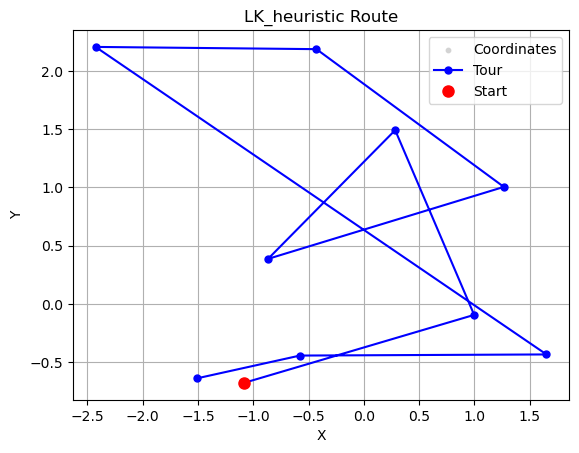

In [34]:
plot_route(path2, coordinates, "LK_heuristic")

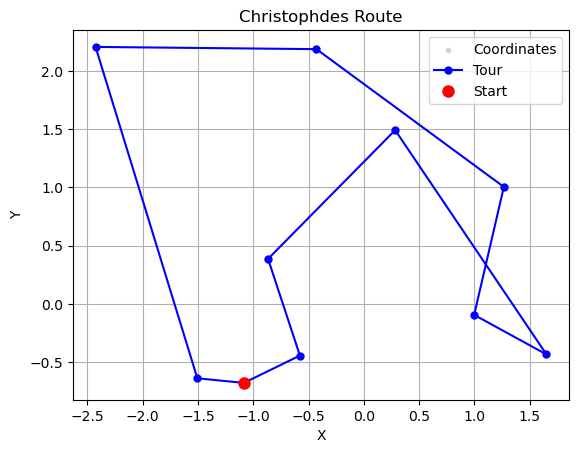

In [35]:
plot_route(path3, coordinates, "Christophdes")

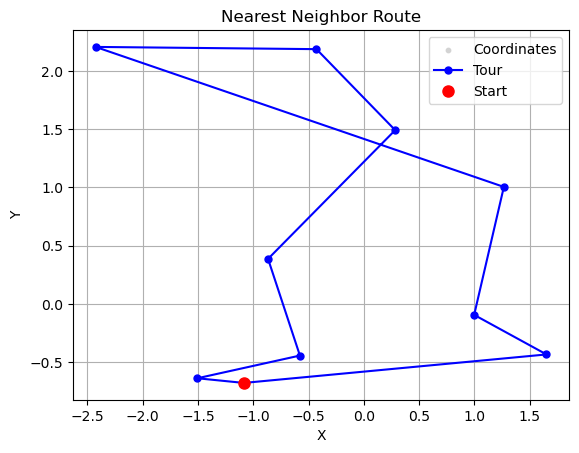

In [36]:
plot_route(path1, coordinates, "Nearest Neighbor")